In [2]:
# import necessary module
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import scipy
from array_response import *
import itertools 

from IPython.display import Image


### Parameters declaration

Declare parameters needed for channel realization

In [2]:
Ns = 1 # number of streams

Nc = 6 # number of cluster
Nray = 1 # number of rays in each cluster

Nt = 64 # number of transmit antennas
Nr = 16 # number of receive antennas

angle_sigma = 10/180*np.pi # standard deviation of the angles in azimuth and elevation both of Rx and Tx

gamma = np.sqrt((Nt*Nr)/(Nc*Nray))
realization = 1000 # equivalent to number of taking sample
count = 0

eps = 0.1 # 20dB isolation
sigma = np.sqrt(8/(1+eps**2)) # according to the normalization condition of H


### Channel Realization

Realize channel H for Dual-Polarized antenna array

In [3]:
H_pol = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
At = np.zeros((Nt,Nc*Nray,realization),dtype=complex)
Ar = np.zeros((Nr,Nc*Nray,realization),dtype=complex)
alpha_hh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_hv = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vv = np.zeros((Nc*Nray,realization),dtype=complex)

AoD = np.zeros((2,Nc*Nray),dtype=complex)
AoA = np.zeros((2,Nc*Nray),dtype=complex)

H = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
azi_rot = np.random.uniform(0,2*np.pi,realization)
ele_rot = np.random.uniform(0,np.pi/2,realization) # Why PI/2 ??
R = np.array([[np.cos(ele_rot)*np.cos(azi_rot),np.sin(ele_rot)],[-np.sin(ele_rot)*np.cos(azi_rot),np.cos(ele_rot)]]) # rotation matrix

for reali in range(realization):
    for c in range(1,Nc+1):
        AoD_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Departure _ azimuth
        AoD_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Departure _ elevation
        AoA_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Arrival_ azimuth
        AoA_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Arrival_ elevation
        AoD[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_azi_m, angle_sigma, (1,Nray))
        AoD[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_ele_m, angle_sigma, (1,Nray))
        AoA[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_azi_m, angle_sigma, (1,Nray))
        AoA[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_ele_m, angle_sigma, (1,Nray))
    for j in range(Nc*Nray):
        At[:,j,reali] = array_response(AoD[0,j],AoD[1,j],Nt) # UPA array response
        Ar[:,j,reali] = array_response(AoA[0,j],AoA[1,j],Nr)
        var_hh = ((sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_hv = ((eps**2)*(sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_vh = ((eps**2)*(sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[1,j])**2)).real
        var_vv = ((sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[1,j])**2)).real
        alpha_hh[j,reali] = np.random.normal(0, np.sqrt(var_hh/2)) + 1j*np.random.normal(0, np.sqrt(var_hh/2))
        alpha_hv[j,reali] = np.random.normal(0, np.sqrt(var_hv/2)) + 1j*np.random.normal(0, np.sqrt(var_hv/2))
        alpha_vh[j,reali] = np.random.normal(0, np.sqrt(var_vh/2)) + 1j*np.random.normal(0, np.sqrt(var_vh/2))
        alpha_vv[j,reali] = np.random.normal(0, np.sqrt(var_vv/2)) + 1j*np.random.normal(0, np.sqrt(var_vv/2))
        alpha = np.vstack((np.hstack((alpha_hh[j,reali],alpha_hv[j,reali])),np.hstack((alpha_vh[j,reali],alpha_vv[j,reali]))))
        H_pol[:,:,reali] = H_pol[:,:,reali] + np.kron(alpha,Ar[:,[j],reali]@At[:,[j],reali].conj().T)
    H_pol[:,:,reali] = gamma* H_pol[:,:,reali]
    H[:,:,reali] = (np.kron(R[:,:,reali],np.eye(Nr)))@H_pol[:,:,reali]
    H[:,:,reali] = np.sqrt(4/3)* H[:,:,reali]


### Check normalized condition

In [4]:
channel_fro_1 = np.zeros(realization)
for reali in range(realization):
    channel_fro_1[reali] = np.linalg.norm(H_pol[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm H pol=", np.mean(channel_fro_1**2))

4*Nt*Nr = 4096    Frobenius norm H pol= 4123.21568255


In [5]:
channel_fro_2 = np.zeros(realization)
for reali in range(realization):
    channel_fro_2[reali] = np.linalg.norm(H[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm =", np.mean(channel_fro_2**2))

4*Nt*Nr = 4096    Frobenius norm = 4136.68372294


### Joint Horizontal/Vertical Beamformer Selection

| hori_tx | hori_rx | verti_tx | verti_rx |
|:--------|--------|--------:|:---------:|

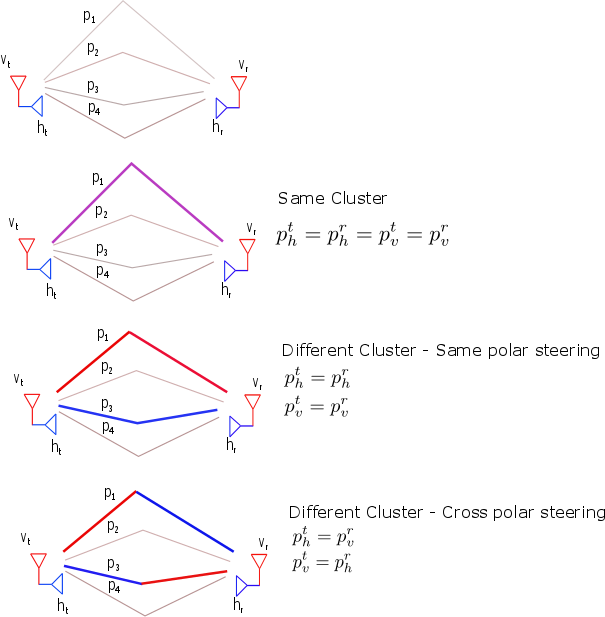

In [3]:
Image("img/cluster.png")

In [6]:
cluster = np.arange(Nc)
print(cluster)
c = list(itertools.combinations(cluster, 2))
num_path = (2*Nc-1)*Nc
path_combi = np.zeros((num_path,4),dtype=int)

print(path_combi.shape)
path_combi[0:Nc,:]=np.arange(Nc).reshape(Nc,1).repeat(4,axis=1)

count = 0
for i in range(int(Nc*(Nc-1)/2)):
    path_combi[Nc+4*i,:] = np.array([c[count][0],c[count][0],c[count][1],c[count][1]])
    path_combi[Nc+4*i+1,:] = np.array([c[count][1],c[count][1],c[count][0],c[count][0]])
    path_combi[Nc+4*i+2,:] = np.array([c[count][0],c[count][1],c[count][1],c[count][0]])
    path_combi[Nc+4*i+3,:] = np.array([c[count][1],c[count][0],c[count][0],c[count][1]])
    count = count+1
# print(path_combi[0:10,:])
path_gain = np.zeros((num_path,realization)) # 2 to save the position and maximum value
for reali in range(realization):
    for combi in range(num_path):
        path_gain[combi,reali] =\
        (np.abs\
         ((np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.sin(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,1])+\
         (np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.sin(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,1])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.cos(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,3])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.sin(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,3])
         ))**2


[0 1 2 3 4 5]
(66, 4)


In [7]:
alpha_hh.shape

(6, 1000)

In [8]:
index = np.zeros(realization,dtype=int)
for test in range(realization):
    index[test] = np.argmax(path_gain[:,test])
    #print(path_gain[index,test])

In [9]:
print(path_combi)

[[0 0 0 0]
 [1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]
 [4 4 4 4]
 [5 5 5 5]
 [0 0 1 1]
 [1 1 0 0]
 [0 1 1 0]
 [1 0 0 1]
 [0 0 2 2]
 [2 2 0 0]
 [0 2 2 0]
 [2 0 0 2]
 [0 0 3 3]
 [3 3 0 0]
 [0 3 3 0]
 [3 0 0 3]
 [0 0 4 4]
 [4 4 0 0]
 [0 4 4 0]
 [4 0 0 4]
 [0 0 5 5]
 [5 5 0 0]
 [0 5 5 0]
 [5 0 0 5]
 [1 1 2 2]
 [2 2 1 1]
 [1 2 2 1]
 [2 1 1 2]
 [1 1 3 3]
 [3 3 1 1]
 [1 3 3 1]
 [3 1 1 3]
 [1 1 4 4]
 [4 4 1 1]
 [1 4 4 1]
 [4 1 1 4]
 [1 1 5 5]
 [5 5 1 1]
 [1 5 5 1]
 [5 1 1 5]
 [2 2 3 3]
 [3 3 2 2]
 [2 3 3 2]
 [3 2 2 3]
 [2 2 4 4]
 [4 4 2 2]
 [2 4 4 2]
 [4 2 2 4]
 [2 2 5 5]
 [5 5 2 2]
 [2 5 5 2]
 [5 2 2 5]
 [3 3 4 4]
 [4 4 3 3]
 [3 4 4 3]
 [4 3 3 4]
 [3 3 5 5]
 [5 5 3 3]
 [3 5 5 3]
 [5 3 3 5]
 [4 4 5 5]
 [5 5 4 4]
 [4 5 5 4]
 [5 4 4 5]]


In [10]:
path_gain[:,1]

array([  5.56163657e-02,   1.63178508e-01,   8.99878825e-02,
         3.97213608e-01,   3.79465947e-02,   2.38065238e-01,
         1.58907303e-02,   7.81883875e-02,   2.69347331e-02,
         5.55270692e-02,   5.78080997e-03,   2.21226142e-02,
         4.38849786e-02,   2.71416826e-02,   2.68551550e-02,
         3.08525341e-01,   1.11402198e-04,   5.68581332e-02,
         7.94464375e-03,   1.51418130e-02,   9.37345727e-03,
         2.41290593e-02,   4.90295093e-03,   3.10947060e-01,
         3.12566140e-02,   8.64416900e-02,   1.88342913e-01,
         4.13421069e-02,   4.36190396e-02,   2.37216881e-02,
         1.12006922e-01,   3.06849080e-01,   2.84339452e-02,
         1.00971790e-01,   1.61987113e-01,   7.18098288e-03,
         1.08467935e-02,   9.09488356e-03,   1.86411438e-01,
         1.48984076e-01,   3.84963400e-02,   3.27038199e-02,
         8.85213470e-03,   2.52871542e-01,   1.40365323e-02,
         1.04967747e-01,   1.59130976e-03,   1.10654717e-02,
         5.38475018e-04,

In [11]:
cross_index =  []
count = 7
while (count<num_path):
    cross_index.extend([count+1,count+2])
    count = count + 4
cross_index = np.array(cross_index)

In [12]:
print(cross_index)
print(cross_index.shape)
print(path_combi[index[1]])

[ 8  9 12 13 16 17 20 21 24 25 28 29 32 33 36 37 40 41 44 45 48 49 52 53 56
 57 60 61 64 65]
(30,)
[3 3 3 3]


In [13]:
cross_index_in = np.isin(index, cross_index)
# print(cross_index_in)
print(sum(cross_index_in))

78


In [14]:
diff_clus_index = np.arange(6,66)
diff_clus_index_in = np.isin(index, diff_clus_index)
# print(diff_clus_index_in)
print(sum(diff_clus_index_in))

326


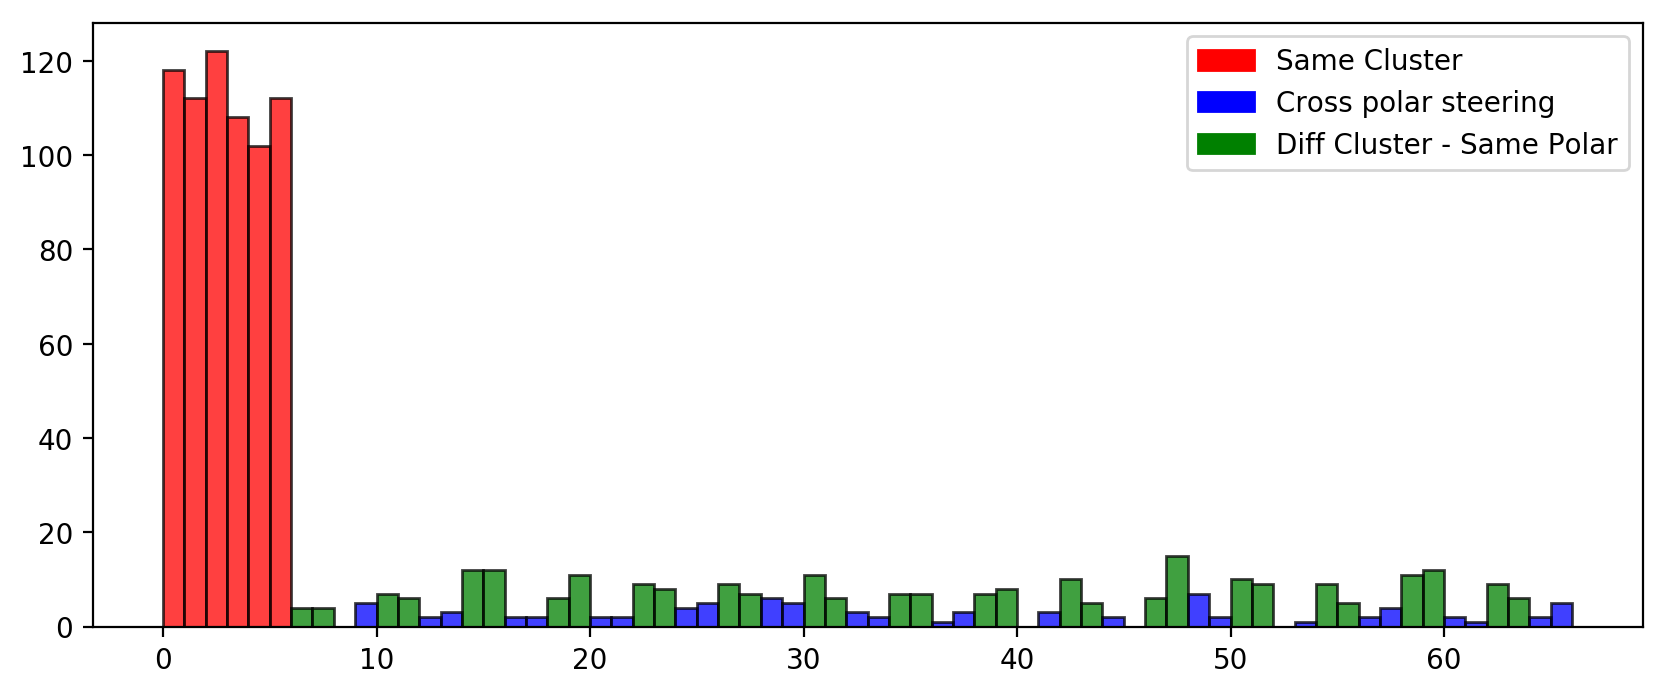

In [15]:
fig = plt.figure(figsize=(10,4), dpi=200)
n, bins, patches = plt.hist(index, bins=range(0,67),facecolor='green', alpha=0.75,edgecolor='black')
# print(n.shape)
# print(bins.shape)
# print(n)
# print(bins)
for i in range(0,6):
    patches[i].set_fc('r')
for i in cross_index:
    patches[i].set_fc('b')
    
cluster_same = mpatches.Patch(color='red', label='Same Cluster')
cross_polar = mpatches.Patch(color='blue', label='Cross polar steering')
diff_clus_same_polar = mpatches.Patch(color='green', label='Diff Cluster - Same Polar')

plt.legend(handles=[cluster_same,cross_polar,diff_clus_same_polar])

plt.show()


In [16]:
unique, counts = np.unique(index, return_counts=True)
print(dict(zip(unique, counts)))


{0: 118, 1: 112, 2: 122, 3: 108, 4: 102, 5: 112, 6: 4, 7: 4, 9: 5, 10: 7, 11: 6, 12: 2, 13: 3, 14: 12, 15: 12, 16: 2, 17: 2, 18: 6, 19: 11, 20: 2, 21: 2, 22: 9, 23: 8, 24: 4, 25: 5, 26: 9, 27: 7, 28: 6, 29: 5, 30: 11, 31: 6, 32: 3, 33: 2, 34: 7, 35: 7, 36: 1, 37: 3, 38: 7, 39: 8, 41: 3, 42: 10, 43: 5, 44: 2, 46: 6, 47: 15, 48: 7, 49: 2, 50: 10, 51: 9, 53: 1, 54: 9, 55: 5, 56: 2, 57: 4, 58: 11, 59: 12, 60: 2, 61: 1, 62: 9, 63: 6, 64: 2, 65: 5}


### Independent Beam Steering Horizontal | Vertical 

In [17]:
steer_path = np.zeros((2,realization),dtype=int)
for reali in range(realization):
    steer_path[0,reali] = np.argmax((np.abs(alpha_hh[:,reali]))**2)
    steer_path[1,reali] = np.argmax((np.abs(alpha_vv[:,reali]))**2)
    

In [18]:
steer_path[:,2]

array([0, 1])

### Plot Spectral Efficiency

In [19]:
SNR_dB = np.arange(-35,10,5)
SNR = 10**(SNR_dB/10)
smax = SNR.shape[0]
R_cross = np.zeros([smax, realization],dtype=complex)
R_steer = np.zeros([smax, realization],dtype=complex)

for reali in range(realization):
    _chosen_combi_path = path_combi[index[reali]]
    _chosen_steer_path = steer_path[:,reali]
    
    W_cross = np.vstack((Ar[:,[_chosen_combi_path[1]],reali],Ar[:,[_chosen_combi_path[3]],reali]))
    F_cross = np.vstack((At[:,[_chosen_combi_path[0]],reali],At[:,[_chosen_combi_path[2]],reali]))
    
    W_steer = np.vstack((Ar[:,[_chosen_steer_path[0]],reali],Ar[:,[_chosen_steer_path[1]],reali]))
    F_steer = np.vstack((At[:,[_chosen_steer_path[0]],reali],At[:,[_chosen_steer_path[1]],reali]))
    
    for s in range(smax):
        R_cross[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+SNR[s]/Ns*np.linalg.pinv(W_cross)@H[:,:,reali]@F_cross@F_cross.conj().T@H[:,:,reali].conj().T@W_cross))
        R_steer[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+SNR[s]/Ns*np.linalg.pinv(W_steer)@H[:,:,reali]@F_steer@F_steer.conj().T@H[:,:,reali].conj().T@W_steer))

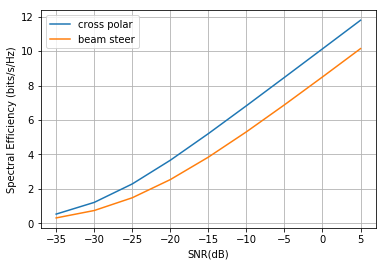

In [20]:
plt.plot(SNR_dB, (np.sum(R_cross,axis=1).real)/realization, label='cross polar')
plt.plot(SNR_dB, (np.sum(R_steer,axis=1).real)/realization, label='beam steer')

plt.legend(loc='upper left')
plt.xlabel('SNR(dB)')
plt.ylabel('Spectral Efficiency (bits/s/Hz)')
plt.grid()
plt.show()